In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import os
from glob import glob
import measures as msp

In [2]:
gpath = 'path to data/'
doctype = 'preprints'
genders = {0:'Male', 1:'Female'}
intervals = {0:[0,1], 1:[1,4], 2:[4,10], 3:[10,999]}
mks = ['o','^','s','*','x']
ms=8
sns.set(style='ticks', font_scale=1.1)
savefig = False

# Plot System Productivity

In [3]:
files = sorted(glob(gpath+'/preprints/preprints*.csv'))

# join all files (separeted per year)
pieces = []
for path in files:
    df_temp = pd.read_csv(path)
    # Apply bands to SciAge
    df_temp['Seniority'] = df_temp.ScientificAge.apply(lambda x: msp.assign_bands(x,intervals))
    df_temp['Date'] = pd.to_datetime(df_temp['Date']).dt.to_period("M")
    pieces.append(df_temp[df_temp['Gender']!=-1])
    allData = pd.concat(pieces, ignore_index=True)
allData.head(3)

,PaperId,AuthorId,Date,Gender,ScientificAge,CountryCode,Seniority
0,3105624533,2031085308,2010-09,0,1.375342,ES,1-4
1,3105894348,2297360158,2010-05,0,8.421918,IT,4-10
2,2027104606,2619972786,2010-10,0,20.827396,PL,10-999


In [4]:
period = 5
sys_prod = msp.compute_sys_productivity(allData, period, '2015-01', '2021-07', genders, intervals) # +1m > open righ, as in range()

In [5]:
df = pd.DataFrame(sys_prod[1:], columns=sys_prod[0])
df['Date'] = pd.to_datetime(df['Date']).dt.to_period("M")
df.head(3)

,Date,All,Male,Female,0-1,1-4,4-10,10-999
0,2015-01,1.416937,1.439181,1.301906,1.123359,1.282929,1.416885,1.557020
1,2015-02,1.423806,1.446632,1.305268,1.121187,1.282628,1.419842,1.569157
2,2015-03,1.427081,1.449529,1.310274,1.122793,1.279509,1.420132,1.577360


In [6]:
def plot_proportion(df_t, ylabel, figname, xlabel=""):
        
    fig, ax = plt.subplots(figsize=(7,5))
    
    #df_sum = df_t.sum(axis=1)
    df_sum = df_t.iloc[:, 1:].sum(axis=1)
    for col in df_t.columns[1:]:
        df_t[col] = df_t[col] / df_sum
    
    # time evolution for panel 1
    df_t.plot.area(x='Date', ax=ax)
    ax.axvline(x='2020-03', color='lightgrey', lw=1, ls='--')
    ax.legend(loc='best')
    ax.set_ylim(0,1)
    ax.set_ylabel(ylabel)
    if not xlabel:
        ax.set_xlabel(f'Date - Past {period+1} months')
    else:
        ax.set_xlabel(xlabel)
    plt.tight_layout()
    if savefig:
        plt.savefig(figname)
    plt.show()


def plot_rel_difference(df_t, ylabel, figname, xlabel="", ylims=""):
    
    fig, ax = plt.subplots(figsize=(7,5))
    
    for i,col in enumerate(df_t.columns[1:]):
        ref = df_t[df_t['Date']=='2020-03'][col].values
        df_t[col] = df_t[col] / ref
        df_t.plot(x='Date', y=col, ax=ax, marker=mks[i], label=col, ms=ms)
    ax.axvline(x='2020-03', color='lightgrey', lw=1, ls='--')
    ax.axhline(y=1, color='lightgrey', lw=1, ls='--')
    ax.legend(loc='best')
    ax.set_ylabel(f'Relative diff. to 2020-03 - {ylabel}')
    if not (not ylims):
        ax.set_ylim(ylims)
    if not xlabel:
        ax.set_xlabel(f'Date - Past {period+1} months')
    else:
        ax.set_xlabel(xlabel)
    sns.despine()
    plt.tight_layout()
    if savefig:
        plt.savefig(figname)
    plt.show()

    
def plot_yearly_difference(df_t, ylabel, figname, ylims=""):
    fig, ax = plt.subplots(figsize=(7,5))
    cols = df_t.columns[1:]
    
    df_t = df_t[(df_t['Date']>='2018-01') & (df_t['Date']<='2021-06')].copy()
    
    for i,col in enumerate(cols):
        df_t[col+'d'] = df_t[col] / df_t[col].shift(12)
        df_t.dropna().plot(x='Date', y=col+'d', ax=ax, marker=mks[i], label=col, ms=ms)
    ax.axvline(x='2020-03', color='lightgrey', lw=1, ls='--')
    ax.axhline(y=1, color='lightgrey', lw=1, ls='--')
    ax.legend(loc='best')
    if not (not ylims):
        ax.set_ylim(ylims)
    ax.set_ylabel(f'Relative diff. previous year - {ylabel}')
    ax.set_xlabel(f'Date - Past {period+1} months')
    sns.despine()
    plt.tight_layout()
    if savefig:
        plt.savefig(figname)
    plt.show()

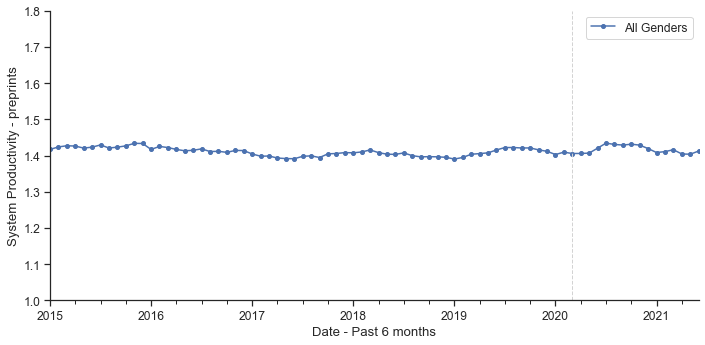

In [8]:
fig, axs = plt.subplots(figsize=(10,5))
ms=4

label = 'All Genders'
df.plot(x='Date', y='All', ax=axs, marker=mks[0], ms=ms, label=label)
axs.axvline(x='2020-03', color='lightgrey', lw=1, ls='--')
axs.set_ylabel('System Productivity - preprints')
axs.set_xlabel(f'Date - Past {period+1} months')
axs.set_ylim(1, 1.8)
sns.despine()
plt.tight_layout()
if savefig:
    plt.savefig(gpath+f'Sys_productivity_{doctype}_{period+1}m.pdf')
plt.show()

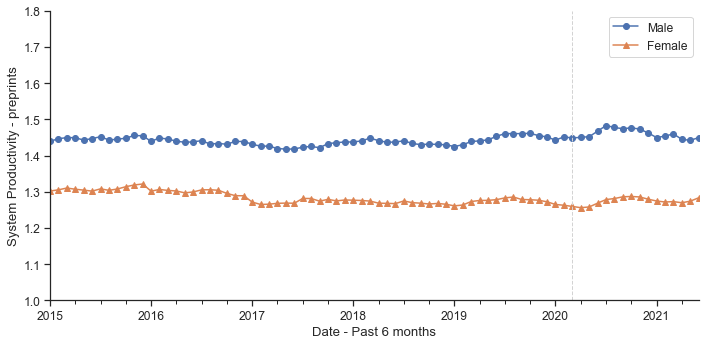

In [9]:
fig, axs = plt.subplots(figsize=(10,5))

for k,v in genders.items():
    df.plot(x='Date', y=v, label=v, ax=axs, marker=mks[k], ms=6)
axs.axvline(x='2020-03', color='lightgrey', lw=1, ls='--')
axs.set_ylabel('System Productivity - preprints')
axs.set_xlabel(f'Date - Past {period+1} months')
axs.set_ylim(1, 1.8)
if savefig:
    plt.savefig(gpath+f'Sys_productivity_{doctype}_gender_{period+1}m.pdf')
sns.despine()
plt.tight_layout()
plt.show()

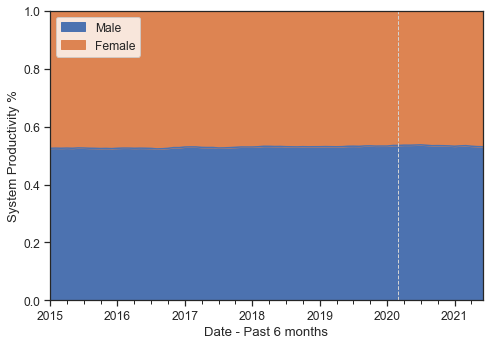

In [10]:
fname = gpath+f'Sys_productivity_{doctype}_gender_{period+1}m.pdf'
plot_proportion(df.loc[:,['Date','Male','Female']],
                'System Productivity %',
                fname)

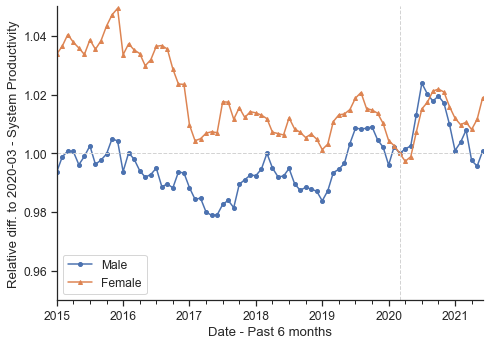

In [11]:
fname = gpath+f'Diff_sys_productivity_{doctype}_gender_{period+1}m.pdf'
plot_rel_difference(df.loc[:,['Date','Male','Female']],
                    'System Productivity',
                    fname,
                    ylims=(0.95, 1.05))

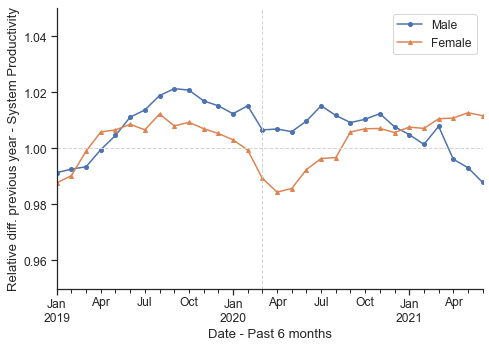

In [12]:
fname = gpath+f'YearlyDiff_sys_productivity_{doctype}_gender_{period+1}m.pdf'
plot_yearly_difference(df.loc[:,['Date','Male','Female']],
                       'System Productivity',
                       fname,
                       (0.95, 1.05))

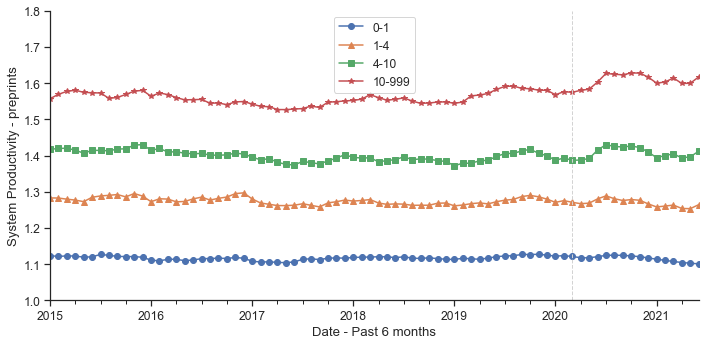

In [13]:
fig, axs = plt.subplots(figsize=(10,5))

for k,v in intervals.items():
    band = f'{v[0]}-{v[1]}'
    df.plot(x='Date', y=band, label=band, ax=axs, marker=mks[k], ms=6)
axs.axvline(x='2020-03', color='lightgrey', lw=1, ls='--')
axs.set_ylabel('System Productivity - preprints')
axs.set_xlabel(f'Date - Past {period+1} months')
axs.set_ylim(1, 1.8)
if savefig:
    plt.savefig(gpath+f'Sys_productivity_{doctype}_seniority_{period+1}m.pdf')
sns.despine()
plt.tight_layout()
plt.show()

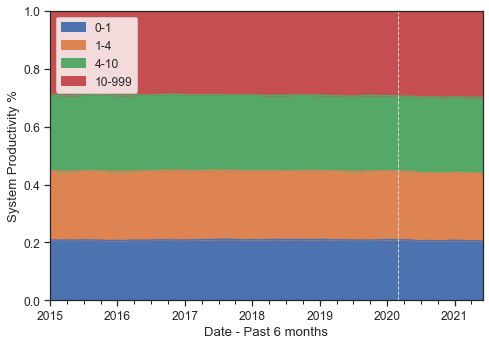

In [14]:
bands = [f'{i}-{j}' for i,j in intervals.values()]
fname = gpath+f'Sys_productivity_{doctype}_seniority_{period+1}m.pdf'
plot_proportion(df.loc[:,['Date']+bands],
                'System Productivity %', fname)

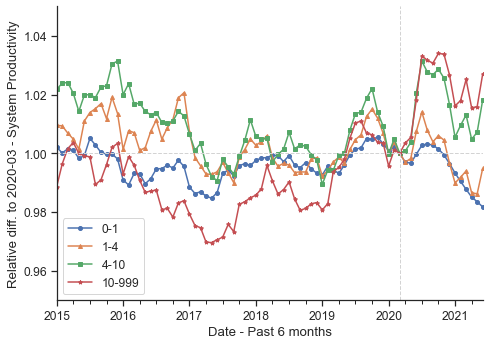

In [15]:
fname = gpath+f'Diff_sys_productivity_{doctype}_seniority_{period+1}m.pdf'
plot_rel_difference(df.loc[:,['Date']+bands],
                    'System Productivity',
                    fname,
                    ylims=(0.95, 1.05))

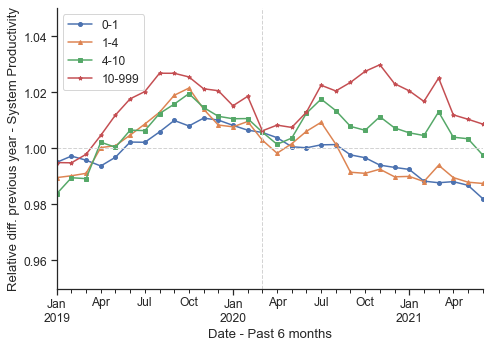

In [16]:
fname = gpath+f'YearlyDiff_sys_productivity_{doctype}_seniority_{period+1}m.pdf'
plot_yearly_difference(df.loc[:,['Date']+bands],
                       'System Productivity',
                       fname,
                       (0.95, 1.05))

# Preprints drill down

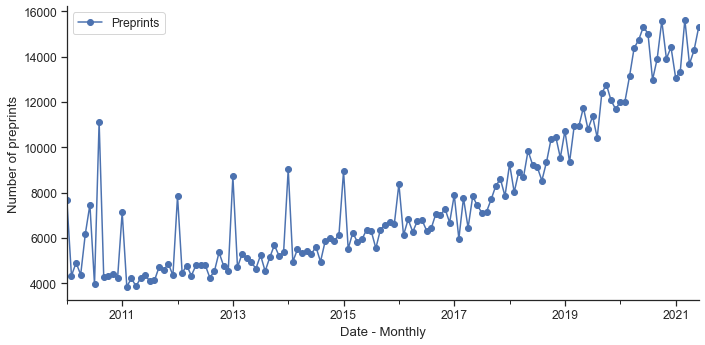

In [17]:
fig, axs = plt.subplots(figsize=(10,5))

allData.groupby('Date')['PaperId'] \
    .nunique() \
    .reset_index(name='Preprints') \
    .plot(x='Date', y='Preprints', ax=axs, marker=mks[0], ms=6)

axs.set_ylabel('Number of preprints')
axs.set_xlabel('Date - Monthly')
if savefig:
    plt.savefig(gpath+f'number_{doctype}.pdf')
sns.despine()
plt.tight_layout()
plt.show()

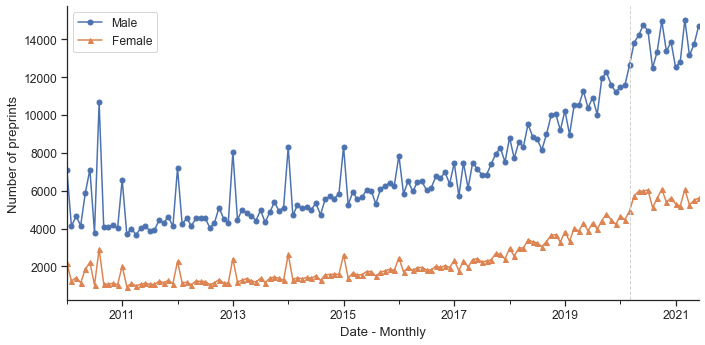

In [18]:
fig, axs = plt.subplots(figsize=(10,5))

groups = allData.groupby(['Date','Gender'])['PaperId'].nunique().reset_index(name='Productivity')
for k,v in genders.items():
    groups[groups['Gender']==k] \
    .plot(x='Date', y='Productivity', label=v, ax=axs, marker=mks[k], ms=5)
axs.set_ylabel('Number of preprints')
axs.axvline(x='2020-03', color='lightgrey', lw=1, ls='--')
axs.set_xlabel('Date - Monthly')
if savefig:
    plt.savefig(gpath+f'number_{doctype}_gender.pdf')
sns.despine()
plt.tight_layout()
plt.show()

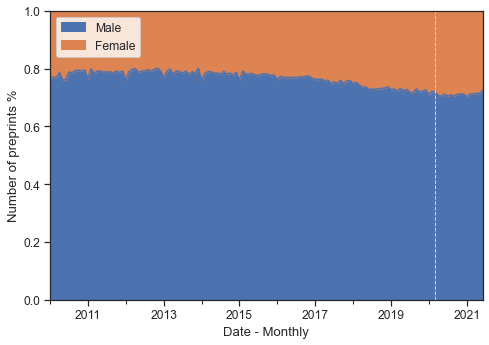

In [19]:
dfg = groups.pivot(index='Date', columns='Gender', values='Productivity').reset_index()
dfg = dfg.rename(columns = genders)

fname = gpath+f'Number_{doctype}_gender.pdf'
plot_proportion(dfg.loc[:,['Date','Male','Female']],
                'Number of preprints %',
                fname,
                'Date - Monthly')

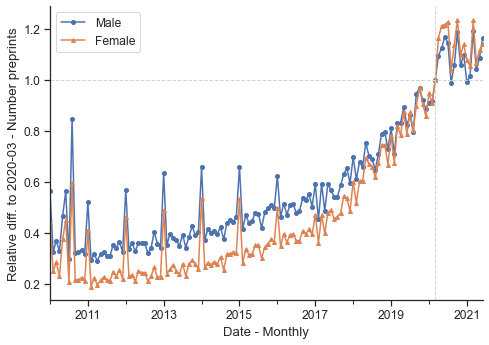

In [20]:
fname = gpath+f'Diff_Number_{doctype}_gender.pdf'
plot_rel_difference(dfg.loc[:,['Date','Male','Female']],
                    'Number preprints',
                    fname,
                    'Date - Monthly')

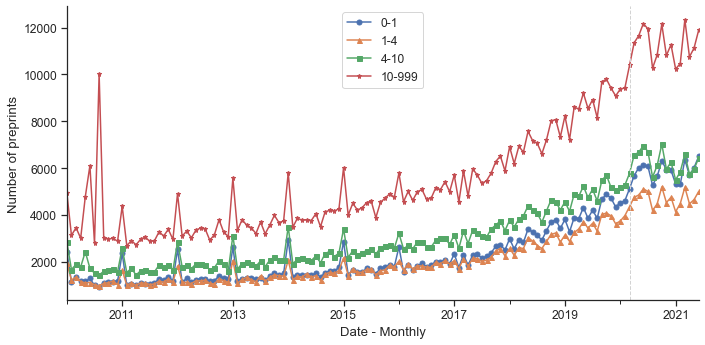

In [21]:
fig, axs = plt.subplots(figsize=(10,5))

groups = allData.groupby(['Date','Seniority'])['PaperId'].nunique().reset_index(name='Productivity')
for k,v in intervals.items():
    band = f'{v[0]}-{v[1]}'
    groups[groups['Seniority']==band] \
    .plot(x='Date', y='Productivity', label=band, ax=axs, marker=mks[k], ms=5)
axs.set_ylabel('Number of preprints')
axs.axvline(x='2020-03', color='lightgrey', lw=1, ls='--')
axs.set_xlabel('Date - Monthly')
if savefig:
    plt.savefig(gpath+f'number_{doctype}_seniority.pdf')
sns.despine()
plt.tight_layout()
plt.show()

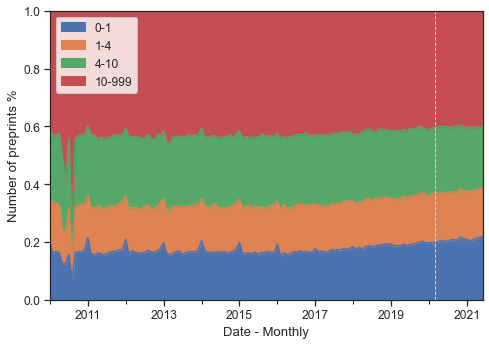

In [22]:
dfg = groups.pivot(index='Date', columns='Seniority', values='Productivity').reset_index()

fname = gpath+f'Number_{doctype}_seniority.pdf'
plot_proportion(dfg.loc[:,['Date']+bands],
                'Number of preprints %',
                fname,
                'Date - Monthly')

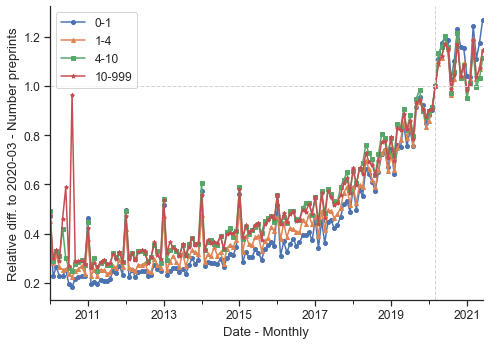

In [23]:
fname = gpath+f'Diff_Number_{doctype}_seniority.pdf'
plot_rel_difference(dfg.loc[:,['Date']+bands],
                    'Number preprints',
                    fname,
                    'Date - Monthly')

# New authors drill down

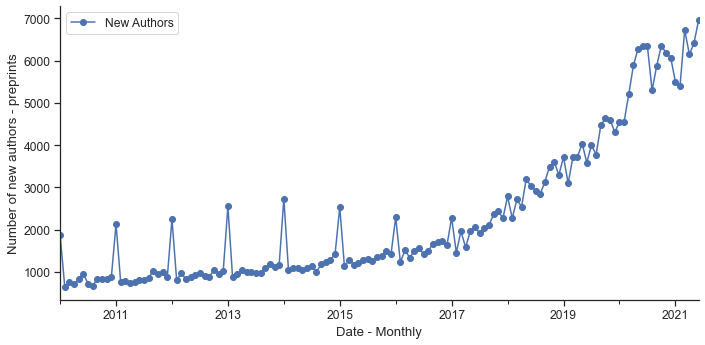

In [7]:
fig, axs = plt.subplots(figsize=(10,5))

new_authors = allData[allData['ScientificAge'] < 0.00001]
new_authors.groupby('Date')['AuthorId'] \
    .nunique() \
    .reset_index(name='New Authors') \
    .plot(x='Date', y='New Authors', ax=axs, marker=mks[0], ms=6)
axs.set_ylabel('Number of new authors - preprints')
axs.set_xlabel('Date - Monthly')
if savefig:
    plt.savefig(gpath+f'new_authors_{doctype}.pdf')
sns.despine()
plt.tight_layout()
plt.show()

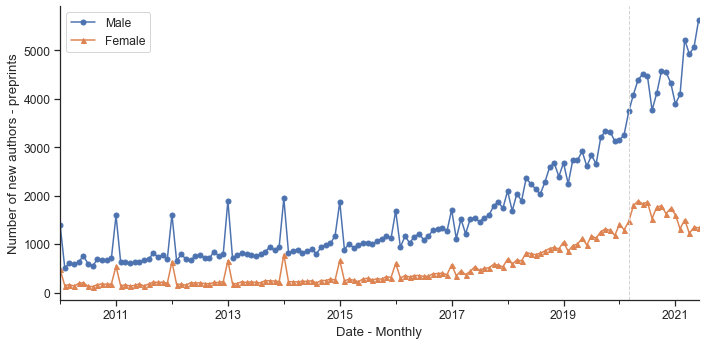

In [12]:
fig, axs = plt.subplots(figsize=(10,5))

groups_NA = new_authors.groupby(['Date','Gender'])['AuthorId'].nunique().reset_index(name='Productivity')
for k,v in genders.items():
    groups_NA[groups_NA['Gender']==k] \
    .plot(x='Date', y='Productivity', label=v, ax=axs, marker=mks[k], ms=5)
axs.set_ylabel('Number of new authors - preprints')
axs.axvline(x='2020-03', color='lightgrey', lw=1, ls='--')
axs.set_xlabel('Date - Monthly')
if savefig:
    plt.savefig(gpath+f'new_authors_{doctype}_gender.pdf')
sns.despine()
plt.tight_layout()
plt.show()

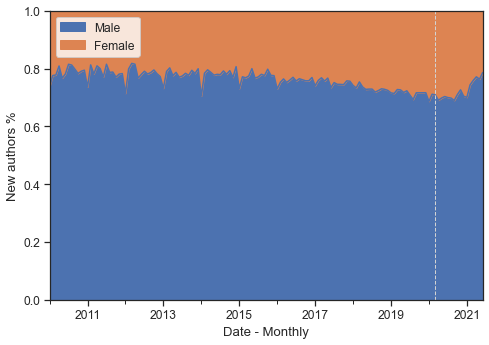

In [26]:
dfg = groups_NA.pivot(index='Date', columns='Gender', values='Productivity').reset_index()
dfg = dfg.rename(columns = genders)

fname = gpath+f'New_authors_{doctype}_gender.pdf'
plot_proportion(dfg.loc[:,['Date','Male','Female']],
                'New authors %',
                fname,
                'Date - Monthly')

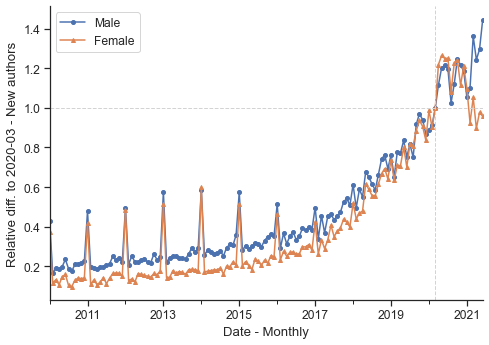

In [27]:
fname = gpath+f'Diff_New_authors_{doctype}_gender.pdf'
plot_rel_difference(dfg.loc[:,['Date','Male','Female']],
                    'New authors',
                    fname,
                    'Date - Monthly')

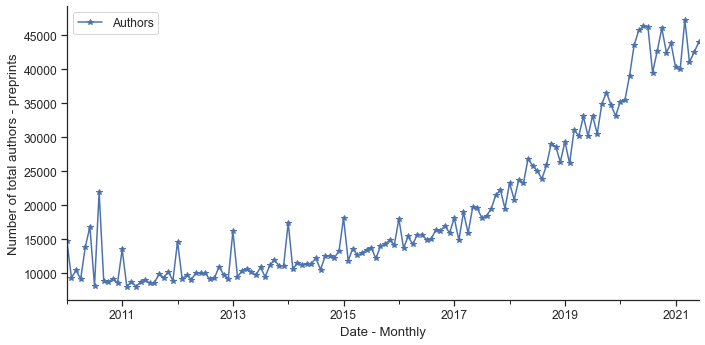

In [31]:
fig, axs = plt.subplots(figsize=(10,5))

allData.groupby('Date')['AuthorId'] \
    .nunique() \
    .reset_index(name='Authors') \
    .plot(x='Date', y='Authors', ax=axs, marker=mks[k], ms=6)

axs.set_ylabel('Number of total authors - preprints')
axs.set_xlabel('Date - Monthly')
if savefig:
    plt.savefig(gpath+f'Total_authors_{doctype}.pdf')
sns.despine()
plt.tight_layout()
plt.show()

# Plot Individual productivity

In [32]:
ind_prod = msp.compute_ind_productivity(allData,
                                        period,
                                        '2015-01',
                                        '2021-07',
                                        genders,
                                        intervals) # +1m > open righ, as in range()

In [33]:
df = pd.DataFrame(ind_prod[1:], columns=ind_prod[0])
df['Date'] = pd.to_datetime(df['Date']).dt.to_period("M")
df.head(3)

,Date,All,Male,Female,0-1,1-4,4-10,10-999
0,2015-01,0.322114,0.336452,0.259015,0.158391,0.222673,0.319392,0.395918
1,2015-02,0.326613,0.341309,0.261748,0.159112,0.226371,0.322385,0.402606
2,2015-03,0.329716,0.344450,0.264571,0.161125,0.230899,0.323369,0.405778


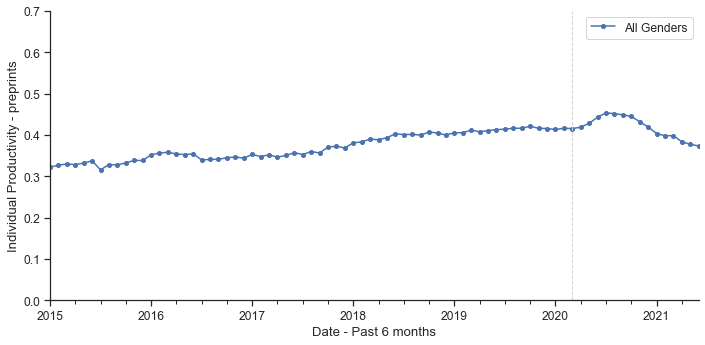

In [34]:
fig, axs = plt.subplots(figsize=(10,5))
ms=4

label = 'All Genders'
df.plot(x='Date', y='All', ax=axs, marker=mks[0], ms=ms, label=label)

axs.set_ylabel('Individual Productivity - preprints')
axs.set_xlabel(f'Date - Past {period+1} months')
axs.axvline(x='2020-03', color='lightgrey', lw=1, ls='--')
axs.set_ylim(0, 0.7)
sns.despine()
plt.tight_layout()
if savefig:
    plt.savefig(gpath+f'Ind_productivity_{doctype}_{period+1}m.pdf')
plt.show()

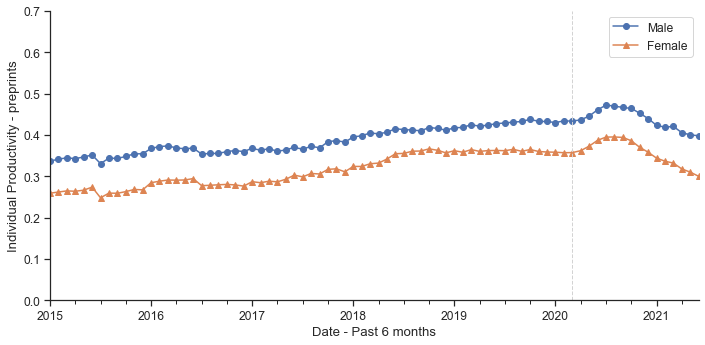

In [35]:
fig, axs = plt.subplots(figsize=(10,5))

for k,v in genders.items():
    df.plot(x='Date', y=v, label=v, ax=axs, marker=mks[k], ms=6)
axs.set_ylabel('Individual Productivity - preprints')
axs.set_xlabel(f'Date - Past {period+1} months')
axs.axvline(x='2020-03', color='lightgrey', lw=1, ls='--')
axs.set_ylim(0, 0.7)
if savefig:
    plt.savefig(gpath+f'Ind_productivity_{doctype}_gender_{period+1}m.pdf')
sns.despine()
plt.tight_layout()
plt.show()

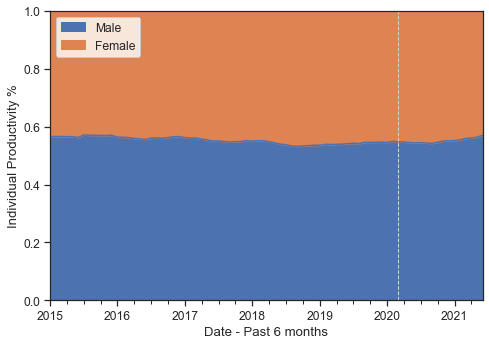

In [36]:
fname = gpath+f'Ind_productivity_{doctype}_gender_{period+1}m.pdf'
plot_proportion(df.loc[:,['Date','Male','Female']], 'Individual Productivity %',fname)

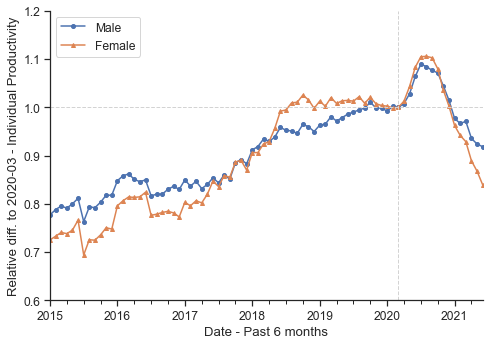

In [37]:
fname = gpath+f'Diff_Ind_productivity_{doctype}_gender_{period+1}m.pdf'
plot_rel_difference(df.loc[:,['Date','Male','Female']],
                    'Individual Productivity',
                    fname,
                    ylims=(0.6, 1.2))

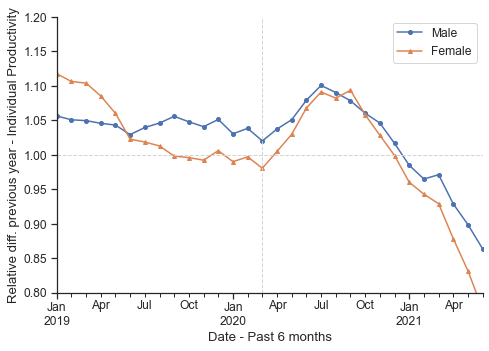

In [38]:
fname = gpath+f'YearDiff_ind_productivity_{doctype}_gender_{period+1}m.pdf'
plot_yearly_difference(df.loc[:,['Date','Male','Female']],
                       'Individual Productivity',
                       fname,
                       (0.8, 1.2))

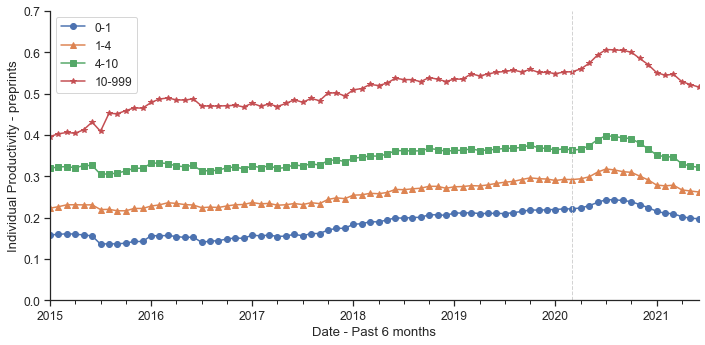

In [39]:
fig, axs = plt.subplots(figsize=(10,5))

for k,v in intervals.items():
    band = f'{v[0]}-{v[1]}'
    df.plot(x='Date', y=band, label=band, ax=axs, marker=mks[k], ms=6)
axs.set_ylabel('Individual Productivity - preprints')
axs.set_xlabel(f'Date - Past {period+1} months')
axs.axvline(x='2020-03', color='lightgrey', lw=1, ls='--')
axs.set_ylim(0, 0.7)
if savefig:
    plt.savefig(gpath+f'Ind_productivity_{doctype}_seniority_{period+1}m.pdf')
sns.despine()
plt.tight_layout()
plt.show()

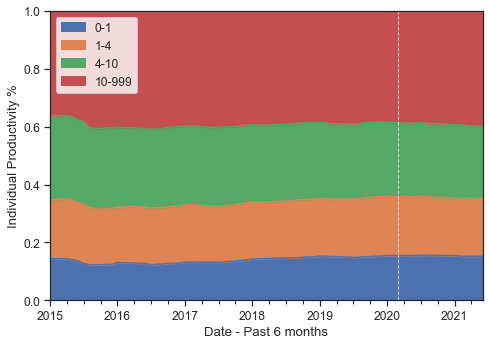

In [40]:
fname = gpath+f'Ind_productivity_{doctype}_seniority_{period+1}m.pdf'
plot_proportion(df.loc[:,['Date']+bands],
                'Individual Productivity %',
                fname)

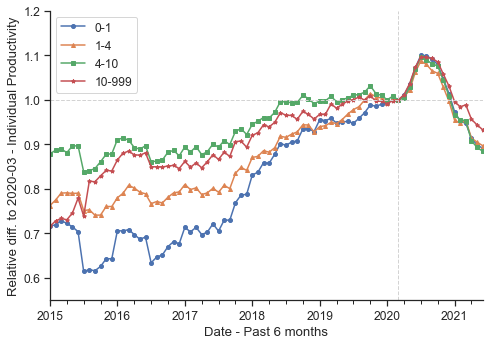

In [41]:
fname = gpath+f'Diff_Ind_productivity_{doctype}_seniority_{period+1}m.pdf'
plot_rel_difference(df.loc[:,['Date']+bands],
                    'Individual Productivity',
                    fname,
                    ylims=(0.55, 1.2))

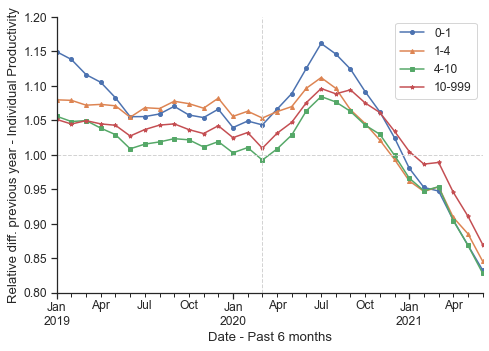

In [42]:
fname = gpath+f'YearDiff_ind_productivity_{doctype}_seniority_{period+1}m.pdf'
plot_yearly_difference(df.loc[:,['Date']+bands],
                       'Individual Productivity',
                       fname,
                       (0.8, 1.2))